<a href="https://colab.research.google.com/github/HilbertN/Redes_Neuronales/blob/main/RN20_Pron%C3%B3sticoTempTarea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ejemplo Prónostico Temperatura

In [1]:
from tensorflow import keras
import numpy as np

Obtenemos los datos y descomprimimos

In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-11-08 22:09:42--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.133.224, 52.216.250.38, 52.216.29.38, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.133.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  5.73MB/s    in 2.3s    

2023-11-08 22:09:46 (5.73 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


# Preparación de los datos

Imprimimos los encabezados y separamos los datos del encabezado

In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")
with open(fname) as f:
   data = f.read()

lines = data.split("\n")
#Esto es útil para dividir un bloque de texto en líneas individuales,
# lo que es comúnmente necesario cuando se trabaja con datos de texto, como un archivo CSV o un archivo de registro.
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


Separamos datos de temperatura y los demás

In [4]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]

In [5]:
raw_data[0,:]

array([ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
        9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
        1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
        1.75000e+00,  1.52300e+02])

Graficamos la serie de tiempo de temperaturas

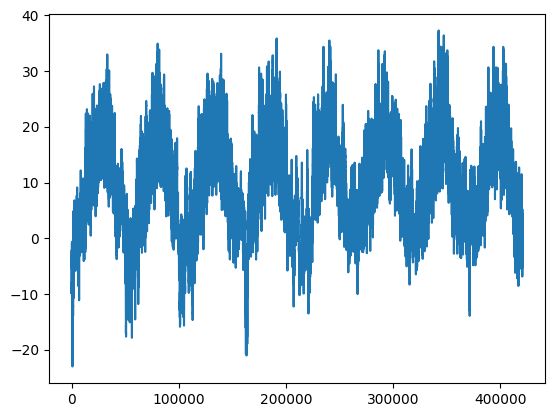

In [6]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

Los datos son tomados cada 10 minutos. Tienen mucha resolución!!. Por ejemplo, podemos graficar los primeros diez días. 24x6=144 <- Es el número de datos correspondiente a un día.

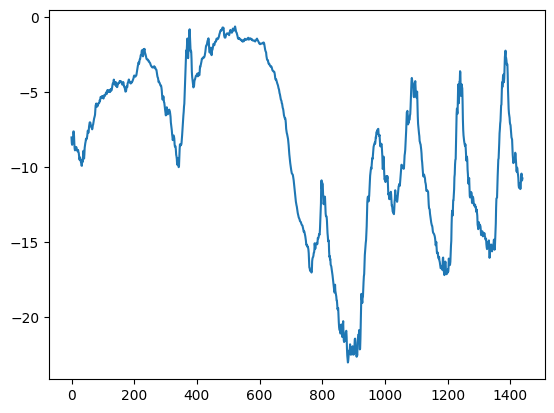

In [7]:
plt.plot(range(1440), temperature[:1440])



1.   Genera secuencias x para entrenamiento (50%), validación (25%) y prueba (25%) de 120 elementos de longitud a partir de los datos de temperatura.
Aquí hay un ejemplo de una forma de lograrlo para generar un conjunto de secuencias:



Calculamos los tamaños de muestra para datos de entrenamiento, validación y prueba.

In [8]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


La formulación exacta del problema será la siguiente: dada una serie de datos que cubre los últimos cinco días y se muestrea una vez por hora, ¿podemos predecir la temperatura en 24 horas?

Primero, vamos a preprocesar los datos a un formato que una red neuronal pueda procesar. Esto es fácil: los datos ya son numéricos, por lo que no necesitas hacer ninguna vectorización. Sin embargo, cada serie temporal en los datos está en una escala diferente (por ejemplo, la presión atmosférica, medida en mbar, está alrededor de 1,000, mientras que H2OC, medida en milimoles por mol, está alrededor de 3). Normalizaremos cada serie temporal de manera independiente para que todas tengan valores pequeños en una escala similar. Utilizaremos los primeros 210,225 pasos de tiempo como datos de entrenamiento, por lo que calcularemos la media y la desviación estándar solo en esta fracción de los datos.

In [9]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [10]:
n=np.array([[1,2,3],[3,4,8],[2,6,7]])
n

array([[1, 2, 3],
       [3, 4, 8],
       [2, 6, 7]])

In [11]:
H=n[:2]
H

array([[1, 2, 3],
       [3, 4, 8]])

In [12]:
m=n[:2].mean(axis=0)
m

array([2. , 3. , 5.5])

In [13]:
H-m

array([[-1. , -1. , -2.5],
       [ 1. ,  1. ,  2.5]])

A continuación, creemos un objeto de conjunto de datos (Dataset) que genere lotes de datos de los últimos cinco días junto con la temperatura objetivo 24 horas en el futuro. Dado que las muestras en el conjunto de datos son altamente redundantes (la muestra N y la muestra N + 1 tendrán la mayoría de sus pasos de tiempo en común), sería un desperdicio de memoria asignar explícitamente memoria para cada muestra. En su lugar, generaremos las muestras sobre la marcha mientras mantenemos en memoria solo los arreglos originales de raw_data y temperatura, y nada más.

Podríamos escribir fácilmente un generador en Python para hacer esto, pero Keras tiene una utilidad de conjunto de datos incorporada que hace justamente eso (timeseries_dataset_from_array()), por lo que podemos ahorrarnos algo de trabajo utilizando esta función. Por lo general, puedes usarla para cualquier tipo de tarea de pronóstico de series temporales.

In [14]:

int_sequence = np.arange(10) #Generamos un array de enteros del 0 al 9
dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],    #secuencia para valores de x
    targets = int_sequence[3:], #secuencia para extraer los valores y
    sequence_length=3, #tamano de las secuencias x
    batch_size=2,  #cada vez que se llame "dataset" nos regresara un batch de 2 secuencias
)


for inputs, targets in dataset:
  print("series x")
  print(inputs)
  print("y")
  print(targets)

series x
tf.Tensor(
[[0 1 2]
 [1 2 3]], shape=(2, 3), dtype=int64)
y
tf.Tensor([3 4], shape=(2,), dtype=int64)
series x
tf.Tensor(
[[2 3 4]
 [3 4 5]], shape=(2, 3), dtype=int64)
y
tf.Tensor([5 6], shape=(2,), dtype=int64)
series x
tf.Tensor([[4 5 6]], shape=(1, 3), dtype=int64)
y
tf.Tensor([7], shape=(1,), dtype=int64)


In [15]:
inputs.shape

TensorShape([1, 3])

O bien, si queremos visualizar de forma mas ordenada

In [16]:
for inputs, targets in dataset:
   for i in range(inputs.shape[0]):
     print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


Utilizaremos timeseries_dataset_from_array() para crear tres conjuntos de datos: uno para entrenamiento, otro para validación y uno más para pruebas.

Utilizaremos los siguientes valores de parámetros:

    sampling_rate = 6: Las observaciones se muestrearán a una tasa de un punto de datos por hora, es decir, conservaremos un punto de datos de cada 6.

    sequence_length = 120: Las observaciones abarcarán un período de 5 días (120 horas). Cada secuencia contendrá 120 puntos de datos.

    delay = sampling_rate * (sequence_length + 24 - 1): Esto se utiliza para determinar el objetivo de cada secuencia. El objetivo será la temperatura 24 horas después del final de la secuencia. El valor de delay se calcula en función de la tasa de muestreo y la longitud de la secuencia.

Al crear el conjunto de datos de entrenamiento, pasaremos start_index = 0 y end_index = num_train_samples para utilizar solo el primer 50% de los datos. Para el conjunto de validación, pasaremos start_index = num_train_samples y end_index = num_train_samples + num_val_samples para utilizar el siguiente 25% de los datos. Finalmente, para el conjunto de pruebas, pasaremos start_index = num_train_samples + num_val_samples para utilizar las muestras restantes.

In [17]:
raw_data[:-4]

array([[ 0.91365151, -1.92064015, -1.97449272, ..., -0.73016651,
        -0.77935289, -0.28119316],
       [ 0.91953033, -1.96510495, -2.01848295, ..., -0.93230685,
        -0.88696976, -0.46989368],
       [ 0.91482727, -1.97650618, -2.0297625 , ..., -1.27790162,
        -1.26147647, -0.05638329],
       ...,
       [ 1.3475084 , -1.43494776, -1.52443881, ..., -0.8214557 ,
        -0.97306326,  0.5504869 ],
       [ 1.33575076, -1.45432985, -1.54248609, ..., -1.03663735,
        -1.1022035 ,  0.3047103 ],
       [ 1.3310477 , -1.46801133, -1.5571495 , ..., -0.96491013,
        -0.87836041,  0.74035224]])

In [18]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
     raw_data[:-delay],
     targets=temperature[delay:],
     sampling_rate=sampling_rate,
     sequence_length=sequence_length,
     shuffle=True,
     batch_size=batch_size,
     start_index=0,
     end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay], targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True, batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [19]:
n[1:]

array([[3, 4, 8],
       [2, 6, 7]])

In [20]:
n[:-2]

array([[1, 2, 3]])

Cada conjunto de datos produce una tupla (muestras, objetivos), donde las muestras son un lote de 256 muestras, cada una conteniendo 120 horas consecutivas de datos de entrada, y los objetivos son el conjunto correspondiente de 256 temperaturas objetivo. Es importante tener en cuenta que las muestras se mezclan de forma aleatoria, por lo que dos secuencias consecutivas en un lote (como muestras[0] y muestras[1]) no necesariamente son cercanas en el tiempo en la secuencia original de datos.

In [21]:
for samples, targets in train_dataset:
  print("samples shape:", samples.shape)
  print("targets shape:", targets.shape)
  break

samples shape: (256, 120, 14)
targets shape: (256,)


# Probando modelos

## Secuencial

De la misma manera en que es útil establecer una línea base de sentido común antes de intentar enfoques de aprendizaje automático, es útil probar modelos de aprendizaje automático simples y económicos (como redes pequeñas densamente conectadas) antes de adentrarse en modelos complicados y computacionalmente costosos como las redes neuronales recurrentes (RNNs). Esta es la mejor manera de asegurarse de que cualquier complejidad adicional que se añada al problema sea legítima y aporte beneficios reales.

El siguiente listado muestra un modelo completamente conectado que comienza por aplanar los datos y luego los pasa por dos capas densas. Observa la ausencia de una función de activación en la última capa densa, lo cual es típico para un problema de regresión. Utilizamos el error cuadrático medio (MSE) como función de pérdida en lugar del error absoluto medio (MAE) porque, a diferencia del MAE, el MSE es suave alrededor de cero, lo cual es una propiedad útil para el descenso de gradientes. Monitorearemos el MAE agregándolo como una métrica en la compilación del modelo

In [22]:
raw_data.shape

(420451, 14)

In [23]:
raw_data.shape[-1]

14

In [40]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model1 = keras.Model(inputs, outputs)
model1.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history1 = model1.fit(train_dataset,epochs=10, validation_data=val_dataset)


Epoch 1/10
819/819 [==============================] - 49s 59ms/step - loss: 12.3193 - mae: 2.7109 - val_loss: 10.3200 - val_mae: 2.5389
Epoch 2/10
819/819 [==============================] - 42s 51ms/step - loss: 8.8630 - mae: 2.3433 - val_loss: 10.2211 - val_mae: 2.5119
Epoch 3/10
819/819 [==============================] - 39s 47ms/step - loss: 8.2001 - mae: 2.2545 - val_loss: 10.5121 - val_mae: 2.5555
Epoch 4/10
819/819 [==============================] - 38s 47ms/step - loss: 7.7953 - mae: 2.1986 - val_loss: 10.1494 - val_mae: 2.5061
Epoch 5/10
819/819 [==============================] - 39s 47ms/step - loss: 7.5075 - mae: 2.1604 - val_loss: 10.9683 - val_mae: 2.6082
Epoch 6/10
819/819 [==============================] - 39s 47ms/step - loss: 7.2580 - mae: 2.1258 - val_loss: 10.7994 - val_mae: 2.5904
Epoch 7/10
819/819 [==============================] - 48s 58ms/step - loss: 7.0492 - mae: 2.0941 - val_loss: 10.6493 - val_mae: 2.5776
Epoch 8/10
819/819 [==============================] - 

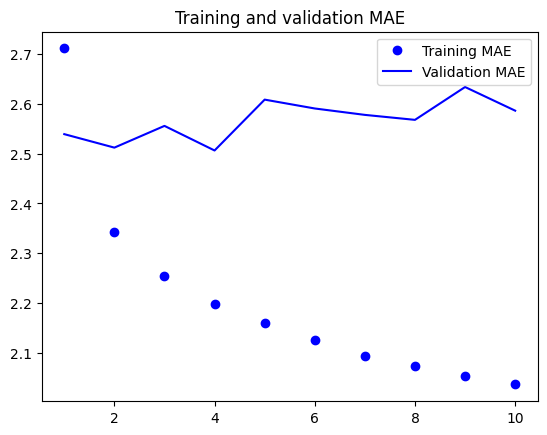

In [43]:
import matplotlib.pyplot as plt
loss = history1.history["mae"]
val_loss = history1.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [44]:
print(f"Test MAE: {model1.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 13s 32ms/step - loss: 11.6304 - mae: 2.6950
Test MAE: 2.70


Algunas de las pérdidas de validación se acercan a la línea de base de no aprendizaje, pero no de manera confiable. Esto demuestra el mérito de tener esta línea de base en primer lugar: resulta que no es fácil superarla. Tu sentido común contiene mucha información valiosa a la cual un modelo de aprendizaje automático no tiene acceso.

Puede que te preguntes, si existe un modelo simple y eficaz para pasar de los datos a los objetivos (la línea de base de sentido común), ¿por qué el modelo que estás entrenando no lo encuentra y mejora? Bueno, el espacio de modelos en el cual estás buscando una solución, es decir, tu espacio de hipótesis, es el espacio de todas las posibles redes de dos capas con la configuración que has definido. La heurística de sentido común es solo un modelo entre millones que pueden representarse en este espacio. Es como buscar una aguja en un pajar. El simple hecho de que una buena solución exista técnicamente en tu espacio de hipótesis no garantiza que podrás encontrarla mediante el descenso de gradientes.

Esta es una limitación significativa del aprendizaje automático en general: a menos que el algoritmo de aprendizaje esté programado para buscar un tipo específico de modelo simple, a veces puede fallar en encontrar una solución sencilla a un problema simple. Es por eso que es esencial aprovechar una buena ingeniería de características y prioridades de arquitectura relevantes: necesitas decirle precisamente a tu modelo qué debe buscar.

## Conv 1D

Hablando de aprovechar las prioridades arquitectónicas correctas, dado que nuestras secuencias de entrada presentan ciclos diarios, tal vez un modelo de convolución podría funcionar. Un convolucional temporal podría reutilizar las mismas representaciones en diferentes días, de manera similar a cómo un convolucional espacial puede reutilizar las mismas representaciones en diferentes ubicaciones en una imagen.

Ya conoces las capas Conv2D y SeparableConv2D, que ven sus entradas a través de pequeñas ventanas que se desplazan por cuadrículas 2D. También existen capas 1D e incluso Versiones en 3D de estas capas: Conv1D, SeparableConv1D y Conv3D. La capa Conv1D utiliza ventanas en 1D que se deslizan por secuencias de entrada, y la capa Conv3D utiliza ventanas cúbicas que se deslizan por volúmenes de entrada.

Por lo tanto, puedes construir convnets en 1D, que son estrictamente análogas a las convnets en 2D. Son ideales para cualquier dato de secuencia que siga la suposición de invariancia a la translación (lo que significa que si deslizas una ventana sobre la secuencia, el contenido de la ventana debe seguir las mismas propiedades de manera independiente de la ubicación de la ventana).

Intentemos utilizar una en nuestro problema de pronóstico de temperatura. Elegiremos una longitud inicial de ventana de 24, de modo que examinemos 24 horas de datos a la vez (un ciclo). A medida que reducimos el muestreo de las secuencias (a través de capas MaxPooling1D), reduciremos el tamaño de la ventana en consecuencia:

In [45]:
inputs=keras.Input(shape=(sequence_length,raw_data.shape[-1]))
x=layers.Conv1D(8,24,activation='relu')(inputs)
x=layers.MaxPooling1D(2)(x)
x=layers.Conv1D(8,12,activation='relu')(x)
x=layers.MaxPooling1D(2)(x)
x=layers.Conv1D(8,6,activation='relu')(x)
x=layers.GlobalAveragePooling1D()(x)
outputs= layers.Dense(1)(x)
model2=keras.Model(inputs,outputs)

model2.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
history2=model2.fit(train_dataset,epochs=10,validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 50s 59ms/step - loss: 22.2193 - mae: 3.7141 - val_loss: 17.6852 - val_mae: 3.3039
Epoch 2/10
819/819 [==============================] - 48s 59ms/step - loss: 15.6587 - mae: 3.1377 - val_loss: 15.2198 - val_mae: 3.0862
Epoch 3/10
819/819 [==============================] - 40s 49ms/step - loss: 13.5014 - mae: 2.9023 - val_loss: 15.9152 - val_mae: 3.1443
Epoch 4/10
819/819 [==============================] - 49s 60ms/step - loss: 12.5190 - mae: 2.7916 - val_loss: 14.8529 - val_mae: 3.0520
Epoch 5/10
819/819 [==============================] - 39s 48ms/step - loss: 11.7852 - mae: 2.7072 - val_loss: 15.8900 - val_mae: 3.1604
Epoch 6/10
819/819 [==============================] - 50s 61ms/step - loss: 11.2444 - mae: 2.6455 - val_loss: 16.2769 - val_mae: 3.2095
Epoch 7/10
819/819 [==============================] - 49s 60ms/step - loss: 10.8211 - mae: 2.5965 - val_loss: 17.7363 - val_mae: 3.3386
Epoch 8/10
819/819 [============================

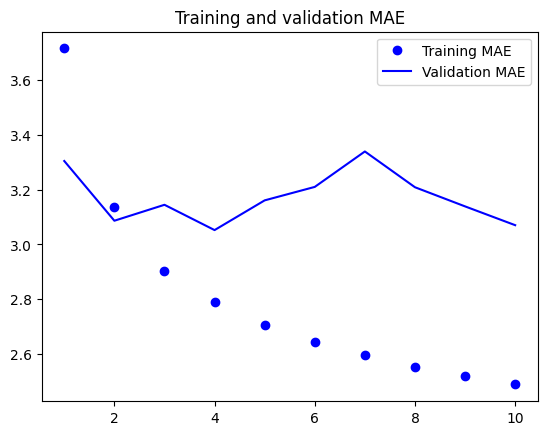

In [46]:
import matplotlib.pyplot as plt
loss = history2.history["mae"]
val_loss = history2.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [34]:
print(f"Test MAE: {model2.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 13s 33ms/step - loss: 15.2122 - mae: 3.1098
Test MAE: 3.11


Resulta que este modelo funciona aún peor que el modelo densamente conectado, logrando solo un MAE de validación de aproximadamente 2.9 grados, lejos del valor de referencia del sentido común. ¿Qué salió mal aquí? Dos cosas:

En primer lugar, los datos meteorológicos no respetan completamente la suposición de invariancia a la translación. Si bien los datos muestran ciclos diarios, los datos de la mañana tienen propiedades diferentes a los de la tarde o de la mitad de la noche. Los datos meteorológicos solo son invariantes a la translación en una escala de tiempo muy específica.

En segundo lugar, el orden de nuestros datos importa, y mucho. El pasado reciente es mucho más informativo para predecir la temperatura del día siguiente que los datos de hace cinco días. Un convnet en 1D no puede aprovechar este hecho. En particular, nuestras capas de max pooling y global average pooling están destruyendo en gran medida la información de orden.

## Redes Recurrentes

Ni el enfoque completamente conectado ni el enfoque convolucional funcionaron bien, pero eso no significa que el aprendizaje automático no sea aplicable a este problema. El enfoque densamente conectado primero aplanó la serie temporal, lo que eliminó la noción de tiempo de los datos de entrada. El enfoque convolucional trató cada segmento de los datos de la misma manera, incluso aplicando el agrupamiento, lo que destruyó la información de orden. En su lugar, veamos los datos tal como son: una secuencia en la que la causalidad y el orden importan.

Existe una familia de arquitecturas de redes neuronales diseñadas específicamente para este caso de uso: las redes neuronales recurrentes. Entre ellas, la capa Long Short Term Memory (LSTM) ha sido muy popular durante mucho tiempo. Veremos en un momento cómo funcionan estos modelos, pero empecemos probando la capa LSTM.


In [47]:
inputs=keras.Input(shape=(sequence_length,raw_data.shape[-1]))
x=layers.LSTM(16)(inputs)
outputs=layers.Dense(1)(x)
model3=keras.Model(inputs,outputs)
model3.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
history3=model3.fit(train_dataset,epochs=10,validation_data=val_dataset)


Epoch 1/10
819/819 [==============================] - 54s 63ms/step - loss: 42.7164 - mae: 4.7620 - val_loss: 12.8119 - val_mae: 2.7187
Epoch 2/10
819/819 [==============================] - 43s 52ms/step - loss: 11.2451 - mae: 2.6026 - val_loss: 9.8384 - val_mae: 2.4420
Epoch 3/10
819/819 [==============================] - 41s 50ms/step - loss: 9.9309 - mae: 2.4530 - val_loss: 9.6097 - val_mae: 2.4099
Epoch 4/10
819/819 [==============================] - 51s 62ms/step - loss: 9.3735 - mae: 2.3884 - val_loss: 9.7725 - val_mae: 2.4181
Epoch 5/10
819/819 [==============================] - 43s 52ms/step - loss: 8.8744 - mae: 2.3243 - val_loss: 9.6501 - val_mae: 2.4037
Epoch 6/10
819/819 [==============================] - 50s 61ms/step - loss: 8.4969 - mae: 2.2731 - val_loss: 10.0198 - val_mae: 2.4488
Epoch 7/10
819/819 [==============================] - 42s 51ms/step - loss: 8.2727 - mae: 2.2401 - val_loss: 10.1502 - val_mae: 2.4712
Epoch 8/10
819/819 [==============================] - 43s

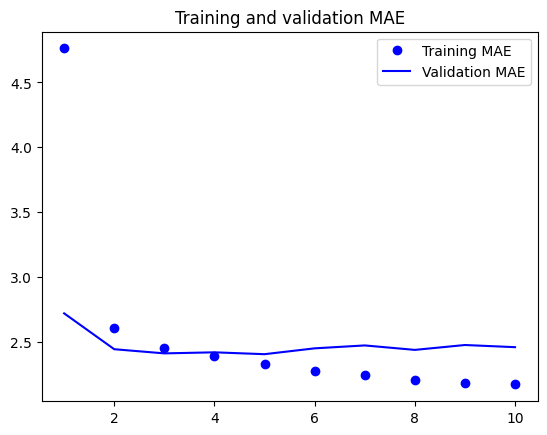

In [48]:
import matplotlib.pyplot as plt
loss = history3.history["mae"]
val_loss = history3.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [49]:
print(f'Test MAE: {model3.evaluate(test_dataset)[1]:.2f}')

405/405 [==============================] - 14s 33ms/step - loss: 10.8106 - mae: 2.5884
Test MAE: 2.59


¡Mucho mejor! Logramos un MAE de validación tan bajo como 2.36 grados y un MAE de prueba de 2.55 grados. El modelo basado en LSTM finalmente puede superar el valor de referencia del sentido común (aunque solo un poco, por ahora), lo que demuestra el valor del aprendizaje automático en esta tarea.
